In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import pandas as pd
import numpy as np
import pickle
import ast


# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, Dropout, Flatten, RepeatVector, Reshape, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

* Load the Dataset

In [2]:
df = pd.read_csv('../../artifacts/data/recent_18_months_les_data_preprocessed_422.csv')
df = df.drop('Lake_data_1D', axis=1)
df.head()

,Date_UTC,Time_UTC,datetime,year_month,day_sin,day_cos,year_sin,year_cos,Wind_x,Wind_y,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,-1.331485e-12,1.000000,-0.999946,-0.010354,9.526279,-5.500000e+00,48.0,93.0,800,4,992.7,0.05
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,2.588190e-01,0.965926,-0.999954,-0.009637,8.457234,-3.078181e+00,48.0,93.0,800,4,993.3,0.05
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,5.000000e-01,0.866025,-0.999960,-0.008920,8.000000,-1.959435e-15,49.0,89.0,600,6,993.0,0.04
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,7.071068e-01,0.707107,-0.999966,-0.008203,8.660254,5.000000e+00,48.0,87.0,1200,8,993.0,0.01
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,8.660254e-01,0.500000,-0.999972,-0.007487,5.142301,6.128356e+00,48.0,86.0,1000,10,993.7,0.00


* Data is not continuous, so lets create the sequence dataset by each window: [2014-10 - 2015-03] + [2015-10 - 2016-03] + [2016-10 - 2017-03]

In [3]:
mnts= df.year_month.unique().tolist()
yr_mnt_lst = []
for i in range(0, len(mnts), 6):
    # print(mnts[i: i+6])
    yr_mnt_lst.append(mnts[i: i+6])

yr_mnt_lst

[['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03'],
 ['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03'],
 ['2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03']]

In [4]:
df['sequence_window'] = -1

for i, val in enumerate(yr_mnt_lst):
    df.loc[df.year_month.isin(val), 'sequence_window'] = i+1


df.sequence_window.value_counts()

sequence_window
2    4392
1    4368
3    4368
Name: count, dtype: int64

### Creating a new feature - day_session 

* 0-8 ==> day-session- 1
* 8-16 ==> day-session- 2
* 16-24 ==> day-session- 3


*Idea: Train a model on 3 records per day - where we select the max precip record from one of the 8-hour duration (day-session)*

In [5]:
df['day_session'] = df['Time_UTC'].apply(lambda x: (int(x[:2])//8))
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')

In [6]:
# Rank order the records of each 8-hour session by Precip values in Descending order
df['RN'] = df.sort_values(['date','day_session', 'Precip_in'], ascending=[True,True, False]).groupby(['date','day_session']).cumcount()+1

Computing the sum-of-precip each day

In [7]:
df['sum_precip_in'] = 0

for i in df.date.unique():
    df.loc[df.date == i, 'sum_precip_in'] = np.round(df[df.date == i].Precip_in.sum(), 6)

df.head()

C:\Users\jkkn7\AppData\Local\Temp\ipykernel_15168\578452082.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.date == i, 'sum_precip_in'] = np.round(df[df.date == i].Precip_in.sum(), 6)


,Date_UTC,Time_UTC,datetime,year_month,day_sin,day_cos,year_sin,year_cos,Wind_x,Wind_y,...,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Precip_in,sequence_window,day_session,date,RN,sum_precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,-1.331485e-12,1.000000,-0.999946,-0.010354,9.526279,-5.500000e+00,...,93.0,800,4,992.7,0.05,1,0,2014-10-01,1,0.15
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,2.588190e-01,0.965926,-0.999954,-0.009637,8.457234,-3.078181e+00,...,93.0,800,4,993.3,0.05,1,0,2014-10-01,2,0.15
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,5.000000e-01,0.866025,-0.999960,-0.008920,8.000000,-1.959435e-15,...,89.0,600,6,993.0,0.04,1,0,2014-10-01,3,0.15
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,7.071068e-01,0.707107,-0.999966,-0.008203,8.660254,5.000000e+00,...,87.0,1200,8,993.0,0.01,1,0,2014-10-01,4,0.15
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,8.660254e-01,0.500000,-0.999972,-0.007487,5.142301,6.128356e+00,...,86.0,1000,10,993.7,0.00,1,0,2014-10-01,5,0.15


---------------------------------------------------
### 2. Loading the Cloud-Images
*Load the Preprocessed Cloud-Images and select respective precip_in values from above data*

In [8]:
feats_req = ['datetime', 'date', 'year_month', 'Time_UTC', 'sum_precip_in']

images_df = df[(df['Time_UTC'] >= '14:00') & (df['Time_UTC'] <= '21:00')][feats_req].reset_index(drop=True)
print(f"Shape of the dataset: {images_df.shape}")

images_df.head()

Shape of the dataset: (4376, 5)


,datetime,date,year_month,Time_UTC,sum_precip_in
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15


In [9]:
from tqdm import tqdm
import cv2

images_array = []

# Load the 128, 128 images
g = '../../artifacts/lake_michigan_images_resized'

img_names = -1
for idx in tqdm(range(len(os.listdir(g)))):
    g_img = g + "/" + str(idx) + ".png"
    im = cv2.imread(g_img)
    # Storing 1 channel, since the images are grayscale, and cropping
    images_array.append(im[8:-8,8:-8,0]) # Crop the 8 pixel border

100%|██████████| 4376/4376 [00:00<00:00, 8896.92it/s]


Plot couple of sequence images from 0th Index

Displaying next frames starting at image 0.


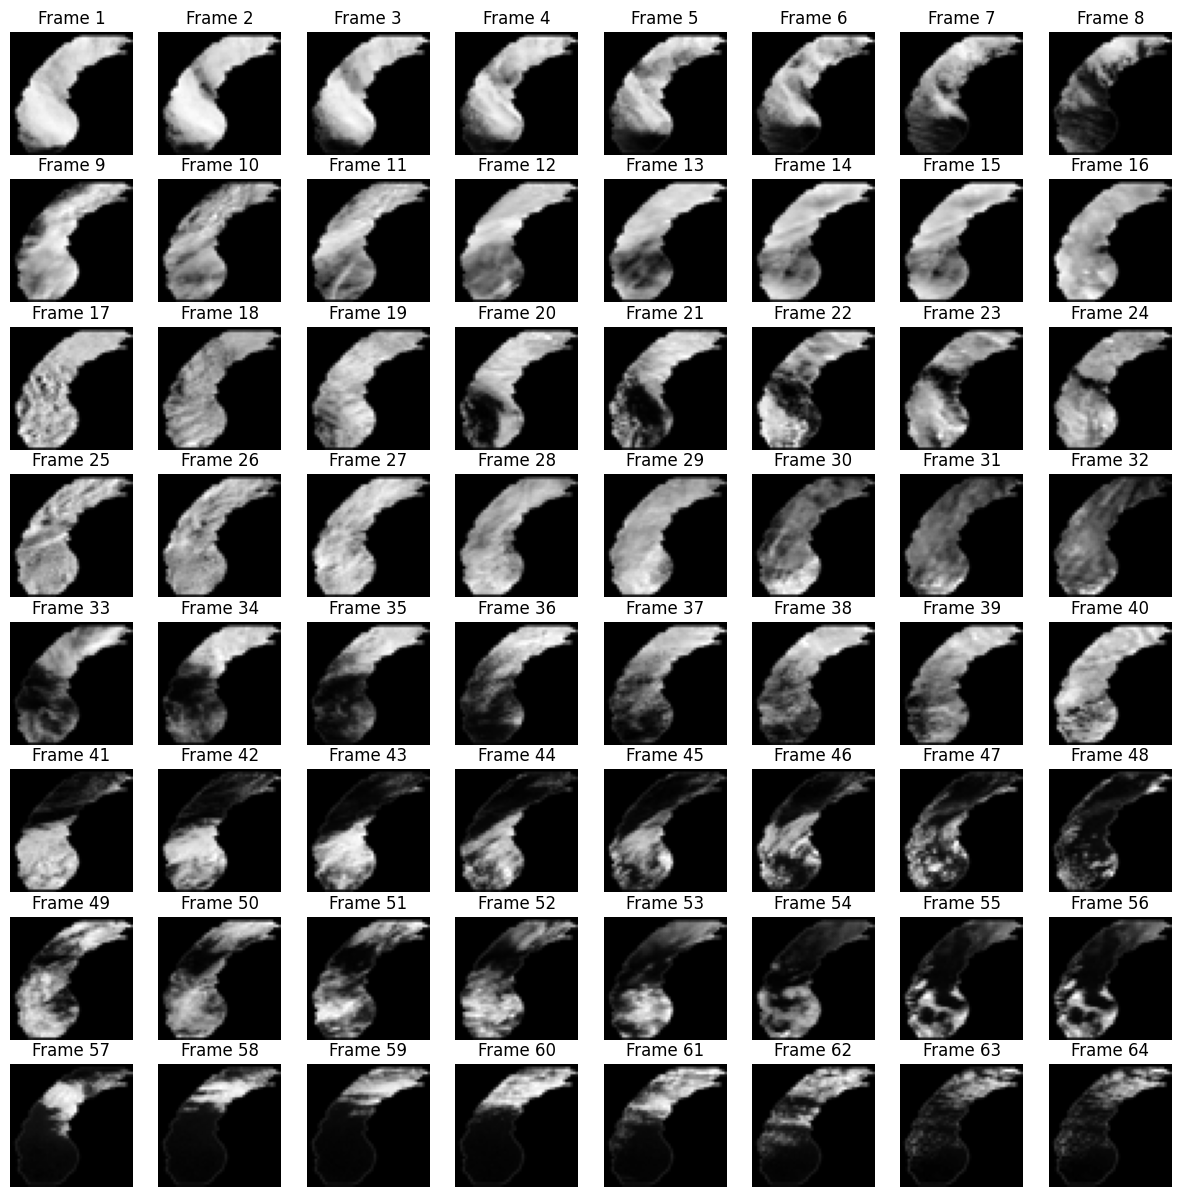

In [10]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(images)), size=1)[0]
data_choice = 0 # Start from 0th index
for idx, ax in enumerate(axes.flat):
    ax.imshow(images_array[data_choice + idx], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying next frames starting at image {data_choice}.")
plt.show()

In [11]:
images_df['image_array'] = images_array
images_df.head()

,datetime,date,year_month,Time_UTC,sum_precip_in,image_array
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


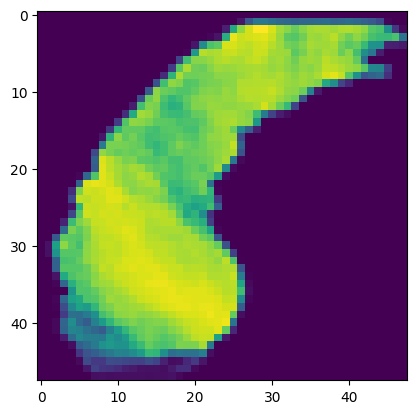

In [12]:
plt.imshow(images_df.image_array[0])

---------------------------------------------------
### 3. Creating the Day Level-data

In [13]:
pd.set_option('display.max_columns', None)
df.head()

,Date_UTC,Time_UTC,datetime,year_month,day_sin,day_cos,year_sin,year_cos,Wind_x,Wind_y,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Precip_in,sequence_window,day_session,date,RN,sum_precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,-1.331485e-12,1.000000,-0.999946,-0.010354,9.526279,-5.500000e+00,48.0,93.0,800,4,992.7,0.05,1,0,2014-10-01,1,0.15
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,2.588190e-01,0.965926,-0.999954,-0.009637,8.457234,-3.078181e+00,48.0,93.0,800,4,993.3,0.05,1,0,2014-10-01,2,0.15
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,5.000000e-01,0.866025,-0.999960,-0.008920,8.000000,-1.959435e-15,49.0,89.0,600,6,993.0,0.04,1,0,2014-10-01,3,0.15
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,7.071068e-01,0.707107,-0.999966,-0.008203,8.660254,5.000000e+00,48.0,87.0,1200,8,993.0,0.01,1,0,2014-10-01,4,0.15
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,8.660254e-01,0.500000,-0.999972,-0.007487,5.142301,6.128356e+00,48.0,86.0,1000,10,993.7,0.00,1,0,2014-10-01,5,0.15


In [20]:
# Group by date and calculate mean for feature1, feature2, feature3 and max for feature4, feature5
day_level_data = df.groupby(df['datetime'].dt.date).agg({
    'day_sin': 'mean',
    'day_cos': 'mean',
    'year_sin': 'mean',
    'year_cos': 'mean',
    'Temp_F': 'mean',
    'RH_pct': 'mean',
    'Low_Cloud_Ht_ft': 'mean',
    'Atm_Press_hPa': 'mean',
    'Wind_x': 'mean',
    'Wind_y': 'mean',
    'Visibility_mi': 'mean',
    'Precip_in': 'sum'
}).reset_index()

day_level_data.columns = ['date', 'day_sin', 'day_cos', 'year_sin', 'year_cos', 'Temp_F','RH_pct', 'Low_Cloud_Ht_ft', 'Atm_Press_hPa', 'Wind_x', 'Wind_y','Visibility_mi', 'sum_precip_in']
day_level_data['date'] = pd.to_datetime(day_level_data['date'])
day_level_data['date'] = day_level_data['date'].dt.strftime('%Y-%m-%d')
day_level_data.head()

,date,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in
0,2014-10-01,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15
1,2014-10-02,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94
2,2014-10-03,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81
3,2014-10-04,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49
4,2014-10-05,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01


In [21]:
day_level_data.sum_precip_in.value_counts(normalize=True)

sum_precip_in
0.00    0.537477
0.01    0.093236
0.02    0.051188
0.03    0.031079
0.04    0.027422
          ...   
0.30    0.001828
0.42    0.001828
0.54    0.001828
0.22    0.001828
0.26    0.001828
Name: proportion, Length: 61, dtype: float64

In [22]:
day_level_data[day_level_data.sum_precip_in > 0].sum_precip_in.describe()

count    253.000000
mean       0.130711
std        0.180845
min        0.010000
25%        0.020000
50%        0.060000
75%        0.160000
max        1.270000
Name: sum_precip_in, dtype: float64

### Classify the Precip into Rain-Classes:
        * 0 - No Rain
        * (0 - 0.06) - Med Rain
        * anything above 0.006 - High Rain

In [23]:
def classify_precip(val):
    high_rain_lower_limit = 0.06
    if val == 0:
        return "No_Rain"
    elif (val > 0) & (val <= high_rain_lower_limit):
        return "Medium_Rain"
    elif (val > high_rain_lower_limit):
        return "High_Rain"

In [24]:
day_level_data['rain_class'] = day_level_data['sum_precip_in'].apply(lambda x: classify_precip(x))
100*day_level_data.rain_class.value_counts(normalize=True)

rain_class
No_Rain        53.747715
High_Rain      23.217550
Medium_Rain    23.034735
Name: proportion, dtype: float64

In [25]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

# Assuming your class variable is named 'classes' and it is a list or array
classes = day_level_data['rain_class'].tolist()  # Your class variable

# Convert class variable to one-hot encoding
label_binarizer = LabelBinarizer()
one_hot_encoded = label_binarizer.fit_transform(classes)

# Convert the one-hot encoded array to a DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded, columns=label_binarizer.classes_)

# Concatenate the one-hot encoded DataFrame with the original DataFrame 'tdf'
day_level_data_with_one_hot = pd.concat([day_level_data, one_hot_df], axis=1)


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)

print("Class weights:")
print(class_weights)

day_level_data_with_one_hot.head()


Class weights:
[1.43569554 1.44708995 0.62018141]


,date,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15,High_Rain,1,0,0
1,2014-10-02,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94,High_Rain,1,0,0
2,2014-10-03,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81,High_Rain,1,0,0
3,2014-10-04,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49,High_Rain,1,0,0
4,2014-10-05,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01,Medium_Rain,0,1,0


### Classify the **precip** values in **Images_df** as well!

In [26]:
images_df.head()

,datetime,date,year_month,Time_UTC,sum_precip_in,image_array
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [27]:
images_df['rain_class'] = images_df['sum_precip_in'].apply(lambda x: classify_precip(x))


# Assuming your class variable is named 'classes' and it is a list or array
classes1 = images_df['rain_class'].tolist()  # Your class variable

# Convert class variable to one-hot encoding
one_hot_encoded1 = label_binarizer.transform(classes1)

# Convert the one-hot encoded array to a DataFrame
one_hot_df1 = pd.DataFrame(one_hot_encoded1, columns=label_binarizer.classes_)

# Concatenate the one-hot encoded DataFrame with the original DataFrame 'tdf'
images_df_with_one_hot = pd.concat([images_df, one_hot_df1], axis=1)
images_df_with_one_hot.head()

,datetime,date,year_month,Time_UTC,sum_precip_in,image_array,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",High_Rain,1,0,0


#### Summary:
We have Day level, 8-hour session level and hourly data with the labels


    * df --- hourly and 8-hour session data
    * images_df, images_df_with_one_hot --- CNN images data
    * day_level_data, day_level_data_with_one_hot --- day level data with agg-precip values

In [21]:
day_level_data_with_one_hot.head()

,date,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,sum_precip_in,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01,55.666667,79.375000,5183.333333,9.250000,0.15,High_Rain,1,0,0
1,2014-10-02,58.708333,85.583333,3075.000000,6.250000,0.94,High_Rain,1,0,0
2,2014-10-03,56.000000,79.041667,3195.833333,8.416667,0.81,High_Rain,1,0,0
3,2014-10-04,49.166667,81.666667,2795.833333,8.875000,0.49,High_Rain,1,0,0
4,2014-10-05,45.000000,68.791667,4120.833333,9.916667,0.01,Medium_Rain,0,1,0


------------------------------------
### Create the Data Sequence for CNN model Training

In [34]:
def create_sequences_cnn(data,  feature_columns, label_columns, stride, past_time_steps=24, future_time_steps=8):
    X, y = [], []
    
    for i in range(0, len(data) - past_time_steps - stride - future_time_steps + 1, stride):
        X.append(data.iloc[i : (i + past_time_steps)][feature_columns].tolist())
        y.append(data.iloc[i + stride + past_time_steps : i + stride + past_time_steps + future_time_steps][label_columns].values[0])
    
    return np.array(X), np.array(y)

In [36]:
# Training data - creating Parameters
stride = 8 # so skipping next day (8- records per day)
past_time_steps = 8 * 3 # 3-days past
future_time_steps = 8 * 1 # 1-day in future (which is next to next date)

######################################################### 1

# 1. Creating the window of sequential data year-months
mnts= images_df_with_one_hot.year_month.unique().tolist()
yr_mnt_lst = []
for i in range(0, len(mnts), 6):
    # print(mnts[i: i+6])
    yr_mnt_lst.append(mnts[i: i+6])


######################################################### 2
### Sequence Training Data - Creating
data_x, data_y = [], []

# feature_cols = ['image_array']
labels_cols = ['High_Rain', 'Medium_Rain', 'No_Rain']

# Creating the Sequence data for each window separately and then appending
for i in yr_mnt_lst:
    # x, y = prepare_data(train_df_scaled, i, cols_to_use, n_time_steps, future_steps)
    x, y = create_sequences_cnn(images_df_with_one_hot[images_df_with_one_hot.year_month.isin(i)], 'image_array', labels_cols, stride, past_time_steps, future_time_steps)
    # print(x.shape, y.shape)
    data_x.append(x)
    data_y.append(y)

######################################################### 3

# Concatenate the arrays along the first axis after the loop
train_x = np.concatenate(data_x, axis=0)
train_y = np.concatenate(data_y, axis=0)
train_x.shape, train_y.shape

((535, 24, 48, 48), (535, 3))

##### The output is of shape: (No_of_batches, No_of_timesteps, Image_Dimesnions)
* 48, 48 - Image size as in the 64*64 image, removed 8+8 border 
* 24 - 8 * 3days as each day has 8 records of cloud image

In [37]:
(train_x[0][0])

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   3,   0,   0],
       [  0,   0,   0, ..., 127,  41,   5],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

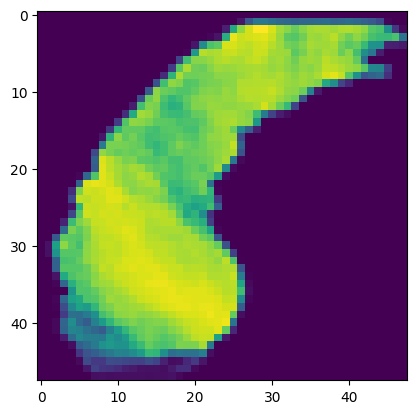

In [38]:
plt.imshow(train_x[0][0])